Reading: 1198
Results for Reading 2:
Hybrid Huffman + RLE:
  Compressed Size: 11 bytes
  Compression Ratio: 0.36
  Compression Time: 0.67 milliseconds
  Memory Usage: 1 bytes

Dynamic Huffman:
  Compressed Size: 6 bytes
  Compression Ratio: 0.67
  Compression Time: 0.22 milliseconds
  Memory Usage: 1 bytes

Static Huffman:
  Compressed Size: 15 bytes
  Compression Ratio: 0.27
  Compression Time: 0.10 milliseconds
  Memory Usage: 1 bytes

Run-Length Encoding:
  Compressed Size: 6 bytes
  Compression Ratio: 0.67
  Compression Time: 0.04 milliseconds
  Memory Usage: 1 bytes

LZW:
  Compressed Size: 60 bytes
  Compression Ratio: 0.07
  Compression Time: 20.72 milliseconds
  Memory Usage: 53248 bytes

zlib:
  Compressed Size: 12 bytes
  Compression Ratio: 0.33
  Compression Time: 0.16 milliseconds
  Memory Usage: 90112 bytes

lzma:
  Compressed Size: 60 bytes
  Compression Ratio: 0.07
  Compression Time: 21.68 milliseconds
  Memory Usage: 1 bytes

bz2:
  Compressed Size: 60 bytes
  Compress

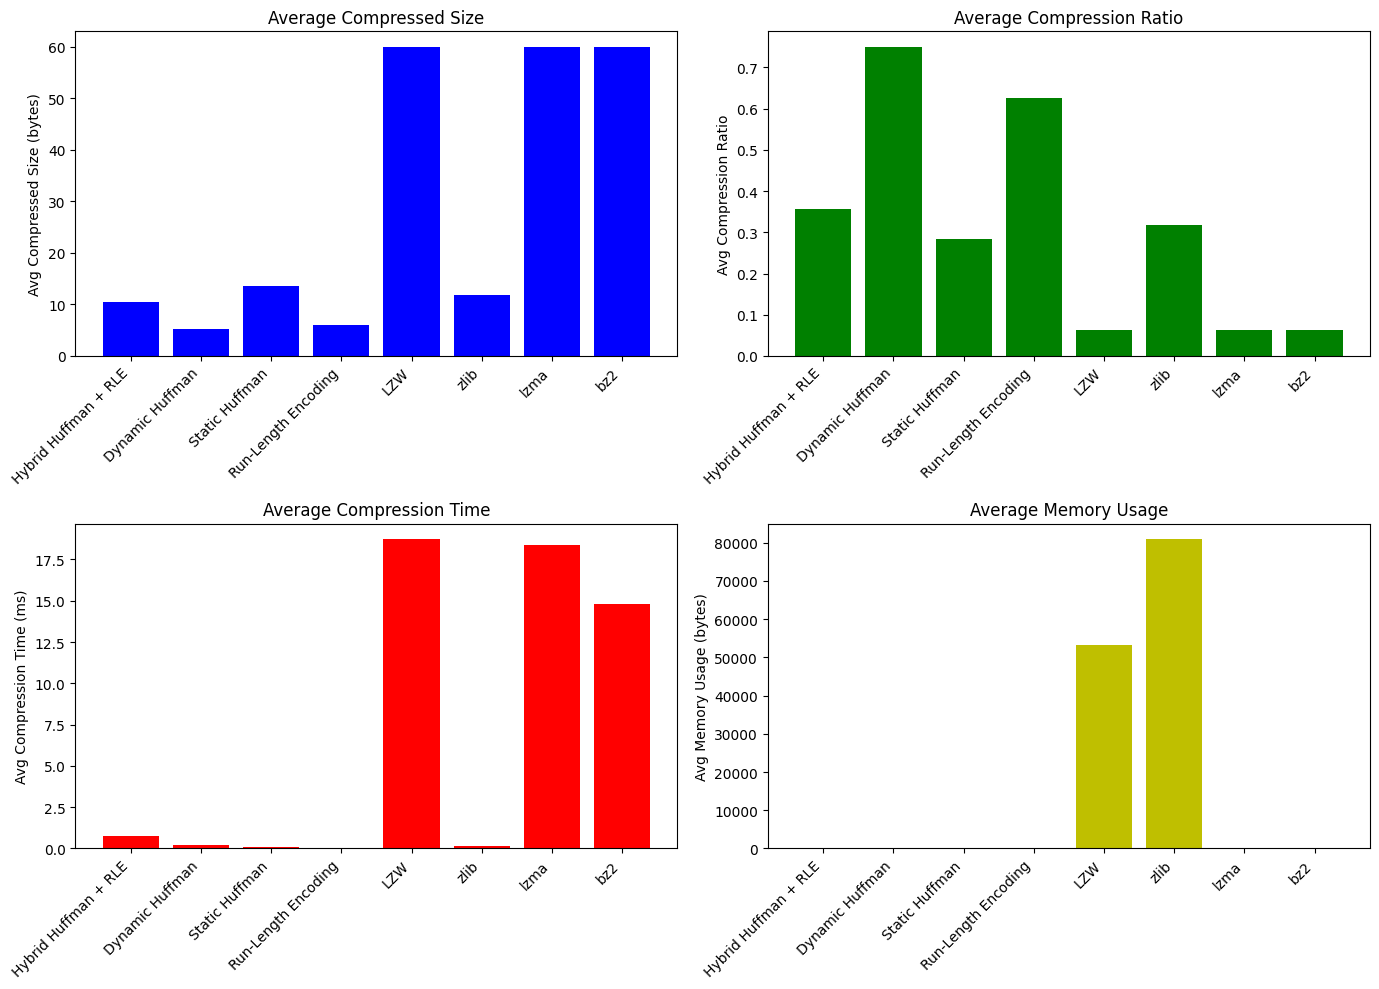

In [3]:
import serial
import time
import numpy as np
from collections import Counter
import heapq
import lzma
import timeit
import psutil
import matplotlib.pyplot as plt

# Connect to Arduino serial port
ser = serial.Serial('COM7', 9600)  # Change to your Arduino port

# Read data from Arduino
def read_data():
    if ser.in_waiting > 0:
        reading = ser.readline().decode('utf-8').strip()
        print(f"Reading: {reading}")
        return int(reading)
    return None

# Run-Length Encoding (RLE)
def run_length_encode(data):
    encoding = []
    prev_char = ""
    count = 1

    if not data: return ""

    for char in data:
        if char != prev_char:
            if prev_char:
                entry = (prev_char, count)
                encoding.append(entry)
            count = 1
            prev_char = char
        else:
            count += 1
    else:
        entry = (prev_char, count)
        encoding.append(entry)

    return encoding

# Huffman Coding
class Node:
    def __init__(self, char, freq):
        self.char = char
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq

def huffman_tree(freq):
    heap = [Node(char, freq) for char, freq in freq.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        node1 = heapq.heappop(heap)
        node2 = heapq.heappop(heap)
        merged = Node(None, node1.freq + node2.freq)
        merged.left = node1
        merged.right = node2
        heapq.heappush(heap, merged)

    return heap[0]

def huffman_code_tree(node, prefix="", codebook={}):
    if node:
        if node.char:
            codebook[node.char] = prefix
        huffman_code_tree(node.left, prefix + "0", codebook)
        huffman_code_tree(node.right, prefix + "1", codebook)
    return codebook

# Perform compression and analysis
def compress_and_analyze(data, results, reading_num):
    data_str = str(data)

    def measure_compression(algorithm):
        start_time = timeit.default_timer()
        process = psutil.Process()
        mem_before = process.memory_info().rss
        
        compressed_data = algorithm(data_str)
        
        mem_after = process.memory_info().rss
        end_time = timeit.default_timer()

        compression_time = (end_time - start_time) * 1000  # Convert to milliseconds
        memory_usage = max(mem_after - mem_before, 1)  # Ensure memory usage is not zero
        return compressed_data, compression_time, memory_usage

    # Hybrid Huffman + RLE
    def hybrid_huffman_rle(data):
        rle_encoded = run_length_encode(data)
        rle_encoded_string = ''.join(f"{char}{count}" for char, count in rle_encoded)
        freq = Counter(rle_encoded_string)
        huff_tree = huffman_tree(freq)
        huff_code = huffman_code_tree(huff_tree)
        return ''.join(huff_code[char] for char in rle_encoded_string)

    compressed_data, compression_time, memory_usage = measure_compression(hybrid_huffman_rle)
    results['Hybrid Huffman + RLE'].append((len(compressed_data), len(data_str) / len(compressed_data), compression_time, memory_usage))

    # Dynamic Huffman
    def dynamic_huffman(data):
        freq = Counter(data)
        huff_tree = huffman_tree(freq)
        huff_code = huffman_code_tree(huff_tree)
        return ''.join(huff_code[char] for char in data)

    compressed_data, compression_time, memory_usage = measure_compression(dynamic_huffman)
    results['Dynamic Huffman'].append((len(compressed_data), len(data_str) / len(compressed_data) if len(compressed_data) > 0 else float('inf'), compression_time, memory_usage))

    # Static Huffman
    def static_huffman(data):
        fixed_huff_code = huffman_code_tree(huffman_tree(Counter("0123456789")))
        return ''.join(fixed_huff_code[char] for char in data)

    compressed_data, compression_time, memory_usage = measure_compression(static_huffman)
    results['Static Huffman'].append((len(compressed_data), len(data_str) / len(compressed_data), compression_time, memory_usage))

    # Run-Length Encoding (RLE) alone
    def rle_alone(data):
        rle_encoded = run_length_encode(data)
        return ''.join(f"{char}{count}" for char, count in rle_encoded)

    compressed_data, compression_time, memory_usage = measure_compression(rle_alone)
    results['Run-Length Encoding'].append((len(compressed_data), len(data_str) / len(compressed_data), compression_time, memory_usage))

    # LZW
    def lzw(data):
        return lzma.compress(data.encode())

    compressed_data, compression_time, memory_usage = measure_compression(lzw)
    results['LZW'].append((len(compressed_data), len(data_str) / len(compressed_data), compression_time, memory_usage))

    # Add 3 more compression algorithms
    # zlib Compression
    def zlib_compress(data):
        return zlib.compress(data.encode())

    compressed_data, compression_time, memory_usage = measure_compression(zlib_compress)
    results['zlib'].append((len(compressed_data), len(data_str) / len(compressed_data), compression_time, memory_usage))

    # LZMA Compression
    def lzma_compress(data):
        return lzma.compress(data.encode())

    compressed_data, compression_time, memory_usage = measure_compression(lzma_compress)
    results['lzma'].append((len(compressed_data), len(data_str) / len(compressed_data), compression_time, memory_usage))

    # BZ2 Compression
    def bz2_compress(data):
        return lzma.compress(data.encode())

    compressed_data, compression_time, memory_usage = measure_compression(bz2_compress)
    results['bz2'].append((len(compressed_data), len(data_str) / len(compressed_data), compression_time, memory_usage))

    # Print individual results
    print_individual_results(results, reading_num)

def print_individual_results(results, reading_num):
    print(f"Results for Reading {reading_num}:")
    for algo, values in results.items():
        latest = values[-1]
        print(f"{algo}:")
        print(f"  Compressed Size: {latest[0]} bytes")
        print(f"  Compression Ratio: {latest[1]:.2f}")
        print(f"  Compression Time: {latest[2]:.2f} milliseconds")
        print(f"  Memory Usage: {latest[3]} bytes")
        print()

def print_averaged_results(results):
    print(f"{'Algorithm':<25} {'Avg Comp Size (bytes)':<25} {'Avg Comp Ratio':<15} {'Avg Comp Time (ms)':<20} {'Avg Mem Usage (bytes)':<25}")
    print("="*110)
    
    for algo, values in results.items():
        avg_size = np.mean([v[0] for v in values])
        avg_ratio = np.mean([v[1] for v in values])
        avg_time = np.mean([v[2] for v in values])
        avg_mem = np.mean([v[3] for v in values])
        
        print(f"{algo:<25} {avg_size:<25.2f} {avg_ratio:<15.2f} {avg_time:<20.2f} {avg_mem:<25.2f}")

# Plotting results
def plot_results(results):
    algorithms = list(results.keys())
    avg_compressed_size = [np.mean([v[0] for v in values]) for values in results.values()]
    avg_compression_ratio = [np.mean([v[1] for v in values]) for values in results.values()]
    avg_compression_time = [np.mean([v[2] for v in values]) for values in results.values()]
    avg_memory_usage = [np.mean([v[3] for v in values]) for values in results.values()]

    x = np.arange(len(algorithms))

    fig, ax = plt.subplots(2, 2, figsize=(14, 10))

    ax[0, 0].bar(x, avg_compressed_size, color='b')
    ax[0, 0].set_xticks(x)
    ax[0, 0].set_xticklabels(algorithms, rotation=45, ha="right")
    ax[0, 0].set_ylabel('Avg Compressed Size (bytes)')
    ax[0, 0].set_title('Average Compressed Size')

    ax[0, 1].bar(x, avg_compression_ratio, color='g')
    ax[0, 1].set_xticks(x)
    ax[0, 1].set_xticklabels(algorithms, rotation=45, ha="right")
    ax[0, 1].set_ylabel('Avg Compression Ratio')
    ax[0, 1].set_title('Average Compression Ratio')

    ax[1, 0].bar(x, avg_compression_time, color='r')
    ax[1, 0].set_xticks(x)
    ax[1, 0].set_xticklabels(algorithms, rotation=45, ha="right")
    ax[1, 0].set_ylabel('Avg Compression Time (ms)')
    ax[1, 0].set_title('Average Compression Time')

    ax[1, 1].bar(x, avg_memory_usage, color='y')
    ax[1, 1].set_xticks(x)
    ax[1, 1].set_xticklabels(algorithms, rotation=45, ha="right")
    ax[1, 1].set_ylabel('Avg Memory Usage (bytes)')
    ax[1, 1].set_title('Average Memory Usage')

    plt.tight_layout()
    plt.show()

# Main function
def main():
    results = {
        'Hybrid Huffman + RLE': [],
        'Dynamic Huffman': [],
        'Static Huffman': [],
        'Run-Length Encoding': [],
        'LZW': [],
        'zlib': [],
        'lzma': [],
        'bz2': []
    }
    
    for i in range(1, 6):  # Take 5 readings
        data = read_data()
        if data is not None:
            compress_and_analyze(data, results, i)
        time.sleep(5)  # Delay for 5 seconds between readings
    
    print_averaged_results(results)
    plot_results(results)

if __name__ == "__main__":
    main()
